In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from housemaze import env as maze
from housemaze import renderer
from housemaze import utils

In [3]:
# rendering fns
def display_image(image):
  # Create a new figure and axis
  fig, ax = plt.subplots()

  # Display the image
  ax.imshow(image)

  # Remove the axis ticks and labels
  ax.axis("off")

  # Show the plot
  plt.tight_layout()
  plt.show()


def render_timestep(timestep):
  image = renderer.create_image_from_grid(
    timestep.state.grid,
    timestep.state.agent_pos,
    timestep.state.agent_dir,
    image_dict,
  )
  plt.imshow(image)
  plt.show()

No file specified for image dict.
Using: /Users/adzcai/Developer/JaxHouseMaze/housemaze/assets/image_data.pkl


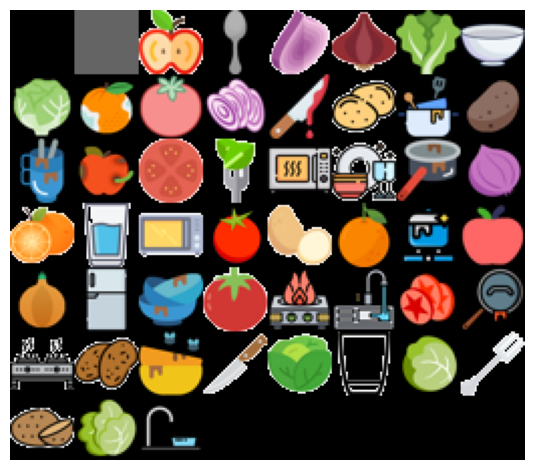

((224, 256, 3),
 ['empty', 'wall', 'apple_sliced', 'spoon', 'onion_sliced_cooked'])

In [4]:
# load images and display them
image_dict = utils.load_image_dict()
image = renderer.create_image_grid_from_image_tensor(image_dict["images"], max_cols=8)
display_image(image)
image.shape, image_dict["keys"][:5]

In [5]:
maze1 = """
.............
.............
.............
.............
...#######...
...#.....#...
...#..>..#...
...#.A...#...
...#...B.#...
...#######...
.............
.............
.............
""".strip()

maze2 = """
.#.C...##....
.#..D...####.
.######......
......######.
.#.#..#......
.#.#.##..#...
##.#.#>.###.#
A..#.##..#...
.B.#.........
#####.#..####
......####.#.
.######E.#.#.
........F#...
""".strip()

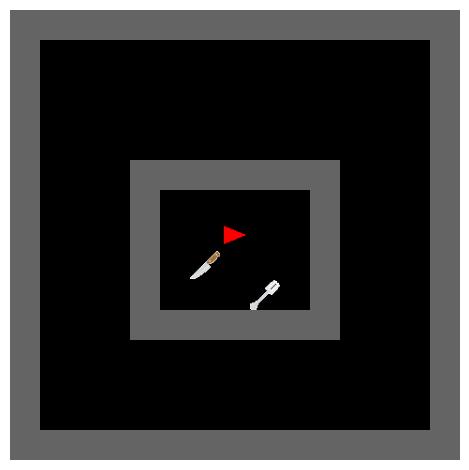

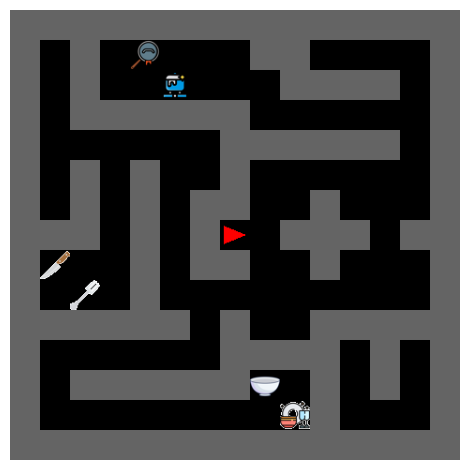

In [6]:
char_to_key = dict(
  A="knife",
  B="fork",
  C="pan",
  D="pot",
  E="bowl",
  F="plates",
)

object_to_index = {key: idx for idx, key in enumerate(image_dict["keys"])}

objects = np.array([object_to_index[v] for v in char_to_key.values()])

map1_init = utils.from_str(
  maze1, char_to_key=char_to_key, object_to_index=object_to_index
)
image = renderer.create_image_from_grid(*map1_init, image_dict)
display_image(image)

map2_init = utils.from_str(
  maze2, char_to_key=char_to_key, object_to_index=object_to_index
)
image = renderer.create_image_from_grid(*map2_init, image_dict)
display_image(image)

In [7]:
# combine both map inits into a single set of params for resetting

map_init = jax.tree.map(lambda *v: jnp.stack(v), *(map1_init, map2_init))
map_init = maze.MapInit(*map_init)
jax.tree.map(lambda x: x.shape, map_init)

MapInit(grid=(2, 13, 13, 1), agent_pos=((2,), (2,)), agent_dir=(2,), spawn_locs=None)

In [8]:
# create env params
env_params = maze.EnvParams(
  map_init=jax.tree.map(jnp.asarray, map_init),
  time_limit=jnp.asarray(50),
  objects=jnp.asarray(objects),
)

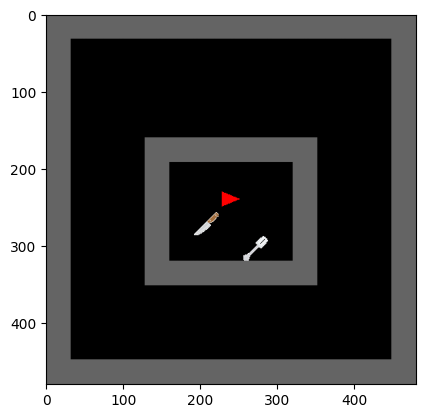

In [9]:
# initialize environment

seed = 6
rng = jax.random.PRNGKey(seed)

task_runner = maze.TaskRunner(task_objects=env_params.objects)
env = maze.HouseMaze(
  task_runner=task_runner,
  num_categories=len(image_dict["keys"]),
)
env = utils.AutoResetWrapper(env)

rng, rng_ = jax.random.split(rng)
reset_timestep = env.reset(rng_, env_params)
render_timestep(reset_timestep)

In [10]:
timestep = reset_timestep
for _ in range(10):
  rng, rng_act, rng_step = jax.random.split(rng, 3)
  action = jax.random.randint(rng_act, (), minval=0, maxval=env.num_actions(env_params))
  timestep = env.step(rng_step, timestep, action, env_params)
  render_timestep(timestep)

TypeError: true_fun output must have same type structure as false_fun output, but there are differences: 
    * at output.state.agent_pos, true_fun output has <class 'tuple'> and false_fun output has pytree leaf, so their Python types differ